In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

paths = glob('/Users/bmmorris/data/kepler7/*slc.fits')

In [2]:
a = 0.06067
per = 4.8854892
rp = 0.08294
t0 = 2454967.27687
duration = 0.213804

In [3]:
paths

['/Users/bmmorris/data/kepler7/kplr005780885-2009291181958_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2009322144938_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2009350160919_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010019161129_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010049094358_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010078100744_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010111051353_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010140023957_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010174090439_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010203174610_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010234115140_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010265121752_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010296114515_slc.fits',
 '/Users/bmmorris/data/kepler7/kplr005780885-2010326094124_slc.fits',
 '/Users/bmmorris/da

In [87]:
from astropy.io import fits

times = []
fluxes = []
for path in paths: 
    f = fits.getdata(path)
    times.append(f['TIME'] + 2454833)
    
    norm_sap = f['SAP_FLUX']/np.nanmedian(f['SAP_FLUX'])
    
    not_nan = ~np.isnan(norm_sap)
    norm_sap /= np.polyval(np.polyfit(f['TIME'][not_nan], norm_sap[not_nan], 1), f['TIME'])
    
    fluxes.append(norm_sap)

times = np.concatenate(times)
fluxes = np.concatenate(fluxes)

times = times[~np.isnan(fluxes)]
fluxes = fluxes[~np.isnan(fluxes)]

(0.99, 1.005)

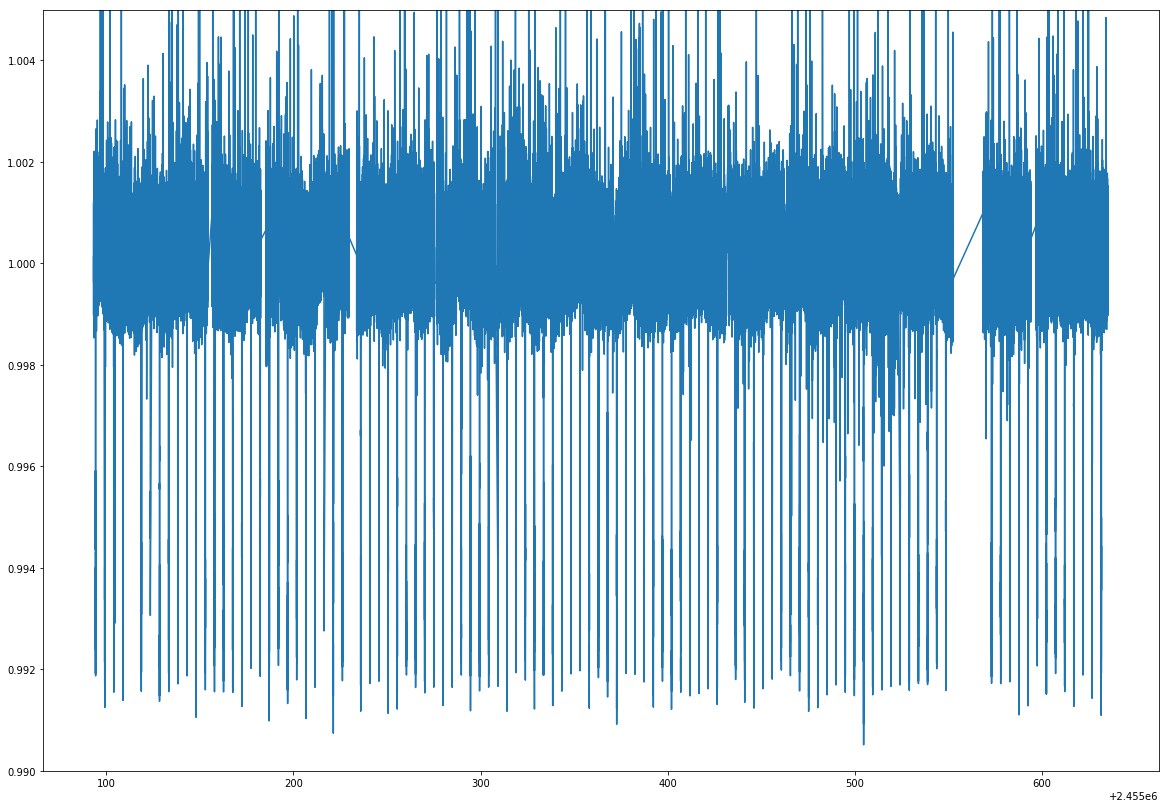

In [88]:
plt.figure(figsize=(20, 14))
plt.plot(times, fluxes)
plt.ylim([0.99, 1.005])

In [89]:
phases = ((times - t0) % per) / per
phases[phases > 0.5] -= 1

In [90]:
mask_transit = np.logical_not(np.abs(phases) < 1.05*duration/per)
mask_eclipse = np.logical_not(np.abs(phases) > 0.5 - 1.05*duration/per)
mask = mask_transit #& mask_eclipse

In [91]:
phases[phases < 0] += 1

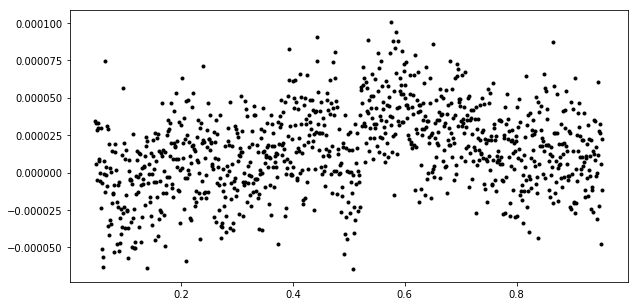

In [94]:
from scipy.stats import binned_statistic

bs = binned_statistic(phases[mask], fluxes[mask], bins=1000, statistic='median')

bs2 = binned_statistic(phases[mask], fluxes[mask], bins=100, statistic='median')

bincenters = 0.5*(bs.bin_edges[1:] + bs.bin_edges[:-1])
binned_time, binned_flux = bincenters, bs.statistic

bincenters2 = 0.5*(bs2.bin_edges[1:] + bs2.bin_edges[:-1])
binned_time2, binned_flux2 = bincenters2, bs2.statistic

during_eclipse = np.abs(binned_time - 0.5) < duration/per/2
binned_flux -= np.median(binned_flux[during_eclipse])

plt.figure(figsize=(10, 5))
# plt.plot(phases, fluxes, '.', alpha=0.001)
plt.plot(binned_time, binned_flux, 'k.')

In [101]:
binned_flux[:400].std()

2.6241133558958494e-05

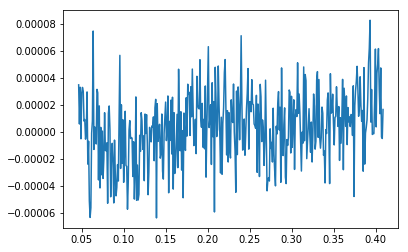

In [100]:
plt.plot(binned_time[:400], )

In [95]:
np.savetxt('data/binned.txt', np.vstack([binned_time, 1e6*binned_flux]).T)

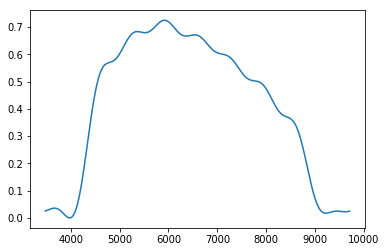

In [10]:
from tynt import FilterGenerator
f = FilterGenerator()
filt = f.reconstruct('Kepler/Kepler.K')
plt.plot(filt.wavelength, filt.transmittance)

In [65]:
import spiderman as sp
spider_params = sp.ModelParams(brightness_model="zhang")
spider_params.n_layers = 5

spider_params.t0 = 0               # Central time of PRIMARY transit [days]
spider_params.per = 1       # Period [days]
spider_params.a_abs = a       # The absolute value of the semi-major axis [AU]
spider_params.inc = 85.161            # Inclination [degrees]
spider_params.ecc = 0.0              # Eccentricity
spider_params.w = 90                 # Argument of periastron
spider_params.rp = rp            # Planet to star radius ratio
spider_params.a = 6.637              # Semi-major axis scaled by stellar radius
spider_params.p_u1 = 0               # Planetary limb darkening parameter
spider_params.p_u2 = 0               # Planetary limb darkening parameter
spider_params.xi = 0     # Ratio of radiative to advective timescale
spider_params.T_n = 2000     # Temperature of nightside
spider_params.delta_T = 1000  # Day-night temperature contrast
spider_params.T_s = 5933    # Temperature of the star
spider_params.l1 = 400e-9       # The starting wavelength in meters
spider_params.l2 = 900e-9       # The ending wavelength in meters
spider_params.limb_dark = 'quadratic'
spider_params.u = [0.4, 0.2]
spider_params.fp = 1e-5
spider_params.t_secondary = 0.5

In [66]:
from batman import TransitModel

eclipse = TransitModel(spider_params, binned_time, transittype='secondary').light_curve(spider_params)
eclipse -= eclipse.min()

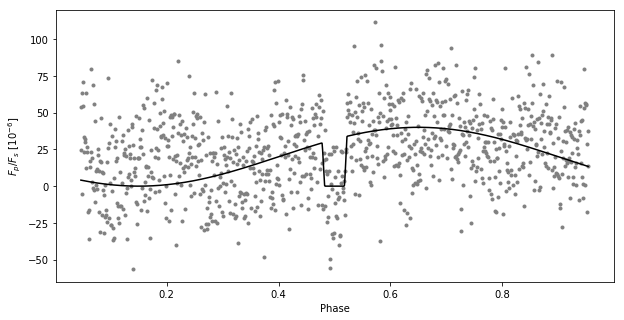

In [67]:

scale = 2
lc = -scale*np.cos(2*np.pi*(binned_time - 0.15)) + scale

plt.figure(figsize=(10, 5))
# plt.plot(phases, fluxes, '.', alpha=0.001)
plt.plot(binned_time, 1e6 * binned_flux, '.', color='gray')
plt.plot(binned_time,  1e6*eclipse * lc, 'k')
plt.xlabel('Phase')
plt.ylabel('$F_p/F_s$ [10$^{-6}$]')
plt.savefig('plots/phase_curve.png', bbox_inches='tight', dpi=200)


Symmetric reflection: 
$$ F_{R}^{S}\left(A_{g}\right)=F_{S}\left(\frac{R_{P}}{a}\right)^{2} A_{g} \frac{1}{\pi}[\sin |\alpha|+(\pi-|\alpha|) \cos |\alpha|] $$

In [68]:
a_rs = 6.637
rp_rs = 0.08294
rp_a = rp_rs / a_rs

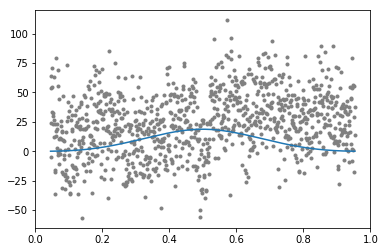

In [69]:
#alpha = np.linspace(-np.pi, np.pi, 100)
alpha = 2 * np.pi * (binned_time - 0.5)
A_B = 0.18
A_g = 2/3 * A_B

def f_R_sym(A_g, times):
    alpha =  2 * np.pi * (times - 0.5)
    return rp_a**2 * A_g / np.pi * (np.sin(np.abs(alpha)) + (np.pi - np.abs(alpha))*np.cos(np.abs(alpha)))

plt.plot(binned_time, 1e6 * binned_flux, '.', color='gray')
plt.plot(binned_time, 1e6 * f_R_sym(A_g, binned_time))

Asymmetric reflection: 

$$\begin{aligned} F_{R}^{A}=& F_{R}^{S}\left(2 r_{0} / 3\right)+F_{S}\left(\frac{R_{P}}{a}\right)^{2} \frac{2 r_{1}}{3} \frac{2}{\pi} \\ & \times \int_{\text { solid }} \cos (\alpha-\phi) \cos (\phi) d \phi \end{aligned} $$

Thermal emission: 

$$ F_{T}=R_{P}^{2} \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} B_{K}[T(\alpha, \theta, \phi)] \cos ^{2} \theta \cos \phi d \theta d \phi $$

$$T(\alpha, \theta, \phi)=f T_{0}(\theta) \mathcal{P}(\epsilon, \xi) $$

$$ T_{0}=T_{S}\left(\frac{R_{S}}{a}\right)^{1 / 2}\left(1-A_{B}\right)^{1 / 4} \cos (\theta)^{1 / 4} $$

$$ \epsilon=\tau_{\mathrm{rad}} \omega_{\mathrm{adv}} $$

$$ \tau_{\mathrm{rad}}=\frac{c_{p} P}{g \sigma T_{0}^{3}} $$

$$\begin{array}{c}{r_{0}=\frac{A_{B}}{1+\frac{2}{3} q^{\prime} \kappa}} \\ {r_{1}=\frac{\kappa A_{B}}{1+\frac{2}{3} q^{\prime} \kappa}}\end{array}$$

$A_{g}=2 A_{B} / 3$

In [71]:
from astropy.modeling.blackbody import blackbody_lambda
from tynt import FilterGenerator
filt = FilterGenerator().download_true_transmittance('Kepler/Kepler.K')

In [72]:
from scipy.integrate import quad
from scipy.optimize import fsolve
from astropy.constants import R_jup, R_sun
import astropy.units as u

temperature = 1200
T_S = 5933
R_p = 1.622 * R_jup
distance = 947 * u.pc
R_star = 1.966 * R_sun

f = 1.23
eps = 3.2

T_0 = T_S * a_rs**-0.5 * (1 - A_B)**0.25 

from calculate_P import PhaseCurve

xi = alpha.copy()
xistep = xi[1] - xi[0]
P = PhaseCurve(eps, xi, xistep).P

T = (f * T_0 * P)[:, np.newaxis]

bb_star = blackbody_lambda(filt.wavelength, T_S)

norm_constant = rp_rs**2 / 2 / np.trapz(bb_star * u.sr * filt.wavelength * filt.transmittance, filt.wavelength).value
int_bb = np.trapz(blackbody_lambda(filt.wavelength, T) * u.sr * filt.wavelength * filt.transmittance, filt.wavelength.value, axis=1).value
F_T = norm_constant * np.array([quad(lambda x: i * np.cos(x), -np.pi/2, np.pi/2)[0] 
                                     for i in int_bb])

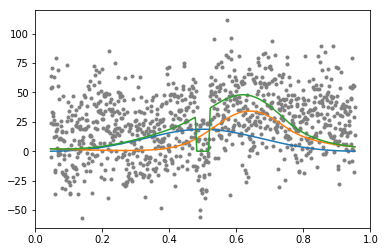

In [86]:
plt.plot(binned_time, 1e6 * binned_flux, '.', color='gray')
plt.plot(binned_time, 1e6 * f_R_sym(A_g, binned_time))
plt.plot(binned_time, 1e6 * F_T)
plt.plot(binned_time, 1e6 * (f_R_sym(A_g, binned_time) + F_T) * eclipse / eclipse.max())